In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from PIL import Image
import os 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import Model
from keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pickle
from  keras_preprocessing.sequence import pad_sequences

In [ ]:
def label_smoothing(y_true,y_pred):
    
     return tf.keras.losses.binary_crossentropy(y_true,y_pred,label_smoothing=0.1)

In [ ]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [ ]:
model1 = load_model('/content/drive/MyDrive/densenet.h5',custom_objects={'label_smoothing': label_smoothing})
image_model_transfer=load_model("/content/drive/MyDrive/image_model_transfer.h5")
decoder_model=load_model("/content/drive/MyDrive/Final_ISRO_DenseNet201_Epoch50.h5",custom_objects={'sparse_cross_entropy': sparse_cross_entropy})

In [ ]:
from  keras.preprocessing.text import Tokenizer

In [ ]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def _init_(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer._init_(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        # word_index is a dictionary. its values are tokens and the keys are words
        # opposite to index_to_word
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""
        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""
        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [ ]:
with open('/content/drive/MyDrive/Train_Label.pickle', 'rb') as efile:
    labels=pickle.load(efile)
with open('/content/drive/MyDrive/tokenizer.pkl', 'rb') as efile:
    tokenizer=pickle.load(efile)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()

In [ ]:
labels=le.fit_transform(labels)

In [ ]:
def framing(video):#defining a small function named"framing" with a parameter "i" that's supposed to be provided for reading the video
    fr = []#creating an empty list named fr
    fr_pre=[]#creating an empty list named fr_pre
    cap = cv2.VideoCapture(video)#reading the video file
    while (cap.isOpened()):#This command builds a loop to check if the data is still being read from the video
        ret,frame = cap.read()#reading the data tunnel,gives two output where one tells about presence of frames(here it's ret) & the other speaks frame data(here it's frame)
        if ret == True:#checking for presence of frames
            # cv2_imshow(frame)#displaying the frames
            grayed = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)#Converting the frames to Grayscale from BGR
            canned = cv2.Canny(grayed,320,320)#For extrating edges we use Canny Edge detection method
            fr.append(frame)#Appending the read frame
            fr_pre.append(canned)#Appending the edge extracted frames
            # cv2_imshow(grayed)#Displaying the original frames
            # cv2_imshow(canned)#Displaying the edge detected frames
            k = cv2.waitKey(10) & 0XFF#this is an arrangement for displaying the video where the secs for which each frame needs to be displayed in given in the paranthesis
            if k == ord('q'):#pressing 'q' key will close the video
                break
        else:
            break
    cap.release()#Here we release the resoures
    cv2.destroyAllWindows()#Here we delete all the windows that were created during the program       
    return fr_pre,fr 

In [ ]:
def difference_of_frames(frames):
    diff = []#creatin a list variable
    for i in range(0,len(frames)-1):#defining the range
        # print(frames[i],frames[i+1])#checking the frames presence
        diff.append(cv2.absdiff(frames[i],frames[i+1]))#appending the diff between frames to the list variable so we're supposed to get only the difference between frames
    return diff

In [ ]:
def cal_threshold(diff):
  mn = np.mean(diff)#This gives mean
  st_d = np.std(diff)#This gives standard deviation
  a = 4#Setting a random value we can modify it to any value 
  ts = mn + (a * st_d)#defining the standard threshold value for the project/global threshold value
  return ts

In [ ]:
def imp_frames(diff, ts, ogframes):
  a_fr = []#Creating an empty list
  for i in range(len(diff)):#Defining the for loop to be looped over all the frames obtained after finding the frames resulted from subtracting
      mn = np.mean(diff[i])#Calculating the mean for each frame
      st_d = np.std(diff[i])#Calculating the standard deviation for each frame
      fr_ts = mn + (4*st_d)#Finding the threshold values for each frame/image
      a_fr.append([i,fr_ts])#Appending the frame number & the threshold values
  imp_fr = []#Creating an empty list
  for i,ac_tr in(a_fr):#Defining the loop on the list obtained from above code
      if ac_tr >= ts:#Comapring the threshold values to the standard threshold/global threshold values
          imp_fr.append([i,ac_tr])#Appending the list with the imp frames based on their index & the values
  key_fr = []#Creating an empty list
  for i,_ in imp_fr:#Defining the loop over the list obtained from above code
      key_fr.append(ogframes[i])#This extracts the frames based on the index of frames 
  return key_fr

In [ ]:
def final_image(video):
  frames,ogframes = framing(video)#calling function framing & then extracting the images 
  diff=difference_of_frames(frames)  
  ts=cal_threshold(diff) 
  key_fr=imp_frames(diff, ts, ogframes)  
  frame_no=key_fr[int(len(key_fr)/2)] #this is a frame
  cv2.imwrite("/content/Testing1.jpg",frame_no)
  return "/content/Testing1.jpg"
  cv2.destroyAllWindows()

In [ ]:
def image_test(image_path):
  image=Image.open(image_path)
  image = image.resize((224,224)) 
  image = np.array(image) 
  image= np.expand_dims(image, axis=0)
  return image

In [ ]:
def largest_indices(ary, n):
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return indices

In [ ]:
mark_start = 'ssss'
mark_end = ' eeee'

In [ ]:
token_start = tokenizer.word_index[mark_start.strip()]
token_end = tokenizer.word_index[mark_end.strip()]

In [ ]:
def load_image(path, size=None):
  """
  Load the image from the given file-path and resize it
  to the given size if not None.
  """

  # Load the image using PIL.
  img = Image.open(path)

  # Resize image if desired.
  if not size is None:
      img = img.resize(size=size, resample=Image.LANCZOS)
      
  img = np.array(img)
  img = img / 255.0

  # Convert 2-dim gray-scale array to 3-dim RGB array.
  if (len(img.shape) == 2):
      img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
  return img

In [ ]:
def greedy_search(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """
    # ---------------------------ENCODE IMAGE--------------------------------
    # Load and resize the image.
    image = load_image(image_path, size=(224,224))
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)
    
    # -------------------------------------------------------------------
    
    
    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start #1

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)
#         print(decoder_output.shape) (1,30,15000) for every iteration
        
        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]
#         print(token_onehot.shape) (15000, ) for every iteration
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
#         print(token_int) #the token of a word with the highest score
        
        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)
#         print(sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
#     print(output_tokens)
    # Plot the image.
    # plt.imshow(image)
    # plt.show()

    predicted_caption=output_text.split()
    del (predicted_caption[-1])
    output_text = " "
    output_text = output_text.join(predicted_caption)

    # Print the predicted caption.
    # print("Predicted caption:")
    # print(output_text)
    # print()
    return predicted_caption

In [ ]:
def beam_search(beam_index, image_path, max_tokens=30):
    image = load_image(image_path, size=(224,224))
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)
    
    token_int = [token_start]
    start_word = [[token_int, 0.0]]
    count_tokens = 0 
    while len(start_word[0][0])<max_tokens:
        temp = []
        
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_tokens, padding='post')
            preds = decoder_model.predict([transfer_values,par_caps], verbose=0)
            token_onehot = preds[0, count_tokens, :]
#             print(token_onehot.shape)
            word_preds = np.argsort(token_onehot)[-beam_index:]
#             print(word_preds.shape)
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += token_onehot[w]
                temp.append([next_cap, prob])
                  
        start_word = temp
        count_tokens+=1
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
                  
    start_word = start_word[-1][0]
    intermediate_caption = [tokenizer.token_to_word(i) for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'eeee':
            final_caption.append(i)
        else:
            break

    # final_caption = ' '.join(final_caption[1:])
    return final_caption[1:]

### Generate Caption

In [ ]:
# def generate_caption_test(idx):
#   data_dir = root_dir
#   filename = filenames_test[idx]
#   captions = captions_test[idx]

#   path = os.path.join(data_dir, filename)
#   true_caption1=captions[0].split()
#   true_caption2=captions[1].split()
#   true_caption3=captions[2].split()

#   print("True captions: ", end ="")
#   # show_image(idx,train=False)
  
#   predicted_caption1=' '.join((greedy_search(image_path=path)))
#   predicted_caption2=' '.join(beam_search(beam_index=3,image_path=path))
#   predicted_caption3=' '.join(beam_search(beam_index=5,image_path=path))

#   print("Predicted using Greedy Search", predicted_caption1)
#   print("Predicted using Beam Search (k=3)", predicted_caption2)
#   print("Predicted using Beam Search (k=5)", predicted_caption3)

In [ ]:
# generate_caption_test(idx=24)

In [ ]:
# def show_image_using_path(img_path):
#     # Load the image and plot it.
#     img = load_image(path)
#     plt.imshow(img)
#     plt.show()

In [ ]:
def generate_caption_any(image_path):

  print("True captions: ", end ="")

  predicted_caption1=' '.join((greedy_search(image_path=image_path)))
  predicted_caption2=' '.join(beam_search(beam_index=3,image_path=image_path))
  predicted_caption3=' '.join(beam_search(beam_index=5,image_path=image_path))

  print("Predicted using Greedy Search: ", predicted_caption1)
  print("Predicted using Beam Search (k=3): ", predicted_caption2)
  print("Predicted using Beam Search (k=5): ", predicted_caption3)
  return predicted_caption2
  # show_image_using_path(image_path)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from PIL import Image

1/1 [==============================] - 3s 3s/step


<ipython-input-22-50859f9c9546>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


1/1 [==============================] - 0s 33ms/step
Predicted using Greedy Search:  the logo is orange and blue in color
Predicted using Beam Search (k=3):  isro logo is seen on black background
Predicted using Beam Search (k=5):  isro logo is seen on black background background


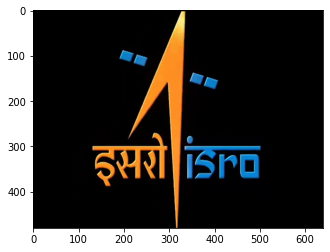

['Logo' 'Building' 'IndoorControlRoom']
isro logo is seen on black background


In [ ]:
path=final_image("/content/Video001-Scene-001.mp4")
image=image_test(path)
# print(image.shape)
output_class=model1.predict(image)
caption=generate_caption_any(path)
indices=largest_indices(output_class, 3)
img = load_image(path)
plt.imshow(img)
plt.show()
print(le.inverse_transform(indices))
print(caption)